<a href="https://colab.research.google.com/github/aminfadaei116/Deep-Learning-Course/blob/master/CA3/Q2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_pretrained_bert 
!pip install transformers 

In [ ]:
import cv2
from scipy.io import loadmat
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linalg as LA
import re
from tqdm.notebook import tqdm
import json
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# makes it easy to write user-friendly command-line interfaces
import argparse
# contains data structures for multi-dimensional tensors
# and mathematical operations over theme
import torch
# helps us in creating and training of the neural network.
import torch.nn as nn
# contains all the functions in the torch.nn library
import torch.nn.functional as F
# implements various optimization algorithms
import torch.optim as optim
# contains datasets with almost similar API
from torchvision import datasets
# contains common image transformations
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# provides several methods to adjust the learning rate based on the number of epochs
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
import pytorch_pretrained_bert 
from transformers import BertTokenizer, BertModel

In [ ]:
Test_Data = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW3-DataSet/Q1/Data/TestD.csv', header = None, encoding = "ISO-8859-1")
Train_Data = pd.read_csv('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW3-DataSet/Q1/Data/TrainD.csv', header = None, encoding = "ISO-8859-1")[0:10000]
Train_Data.columns = ['label', 'sentence']
Test_Data.columns = ['label', 'sentence']

In [ ]:
sentence_size = []
for i in range(Train_Data.shape[0]):
  sentence_size.append(len(Train_Data.loc[i]['sentence'].split()))
max_size = max(sentence_size)
print(max_size)

86


In [ ]:
def string_to_float(str_arr):
  numbers = str_arr.split()
  float_num = [float(num) for num in numbers]
  return float_num

def zerolistmaker(n):
  listofzeros = [0] * n
  return listofzeros

def calc_acc(output1, batch_y, num):
  return ((torch.argmax(output1, dim=1) == batch_y).sum().to(dtype=torch.float32))/num

# this part has been taken from the internet and it is from the https://scikit-learn.org/
def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
        


def plot_matrix(cm,
                title=None,
                cmap=plt.cm.Blues):
    
    if not title:
        title = 'Confidence matrix'

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Number of available devices:', torch.cuda.device_count())
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
#!kill -9 -1 # if memory was low or no memory

Number of available devices: 1
Gen RAM Free: 12.3 GB  | Proc size: 843.6 MB
GPU RAM Free: 11430MB | Used: 11MB | Util   0% | Total 11441MB


In [ ]:
class Tweet_Data_BERT(Dataset):
  def __init__(self, dataFrame, padding_size):
    self.length = dataFrame.shape[0]
    self.pad_size = padding_size
    self.The_df = dataFrame
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


  def __getitem__(self, index):
    label = torch.tensor(self.The_df.loc[index]["label"], dtype = torch.uint8)
    tweet = self.The_df.loc[index]["sentence"]
    tokens = self.tokenizer.encode_plus(text = tweet, add_special_tokens = True, max_length = self.pad_size, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids = tokens["input_ids"] 
    attention_mask = tokens["attention_mask"]
    return int(label), input_ids, attention_mask
    
  def __len__(self):
    return self.length

In [ ]:
PAD_SIZE = 2 * max_size
DataSize = len(Train_Data)
MyTrainDataSet = Tweet_Data_BERT(Train_Data[0:int(DataSize*0.95)], PAD_SIZE)
MyValidactionDataSet =Tweet_Data_BERT(Train_Data[int(DataSize*0.95):].reset_index(), PAD_SIZE)
MyTestDataSet = Tweet_Data_BERT(Test_Data, PAD_SIZE)

In [ ]:
BATCH_SIZE = 32
TrainData = torch.utils.data.DataLoader(dataset=MyTrainDataSet, batch_size=BATCH_SIZE, shuffle=True)
ValidationData = torch.utils.data.DataLoader(dataset=MyValidactionDataSet, batch_size=len(MyValidactionDataSet))
TestData = torch.utils.data.DataLoader(dataset=MyTestDataSet, batch_size=len(MyTestDataSet))

In [ ]:
class BERT_NET(nn.Module):
  def __init__(self):
    super(BERT_NET, self).__init__()
    self.BERT_Layer = BertModel.from_pretrained("bert-base-uncased", num_labels = 3,output_attentions = False, output_hidden_states = False)   
    self.Fc1 = nn.Linear(768, 3)
    self.train_loss = []
    self.test_loss = []
    self.val_loss = []
    self.acc_train = []
    self.acc_test = []
    self.acc_val = []

  def forward(self, input_ids2, attention_mask2):
    input_ids2 = input_ids2.squeeze()
    attention_mask2 = attention_mask2.squeeze()
    output, _ = self.BERT_Layer(input_ids = input_ids2, attention_mask = attention_mask2)
    scores = self.Fc1(output[:,-1,:])
    return F.softmax(scores, dim = 1)

def Train_NetWork(model, epoch_number):
  model.train()
  optimizer = optim.Adam([{"params":model.BERT_Layer.parameters(),"lr": 0.00001},{"params":model.Fc1.parameters(), "lr": 0.01},])
  for epoch in range(epoch_number):
    for i, (labels, inputs_ids, mask_attention) in enumerate(TrainData):
      inputs_ids = inputs_ids.to(device)
      labels = labels.to(device)
      mask_attention = mask_attention.to(device)
      optimizer.zero_grad()
      output2 = model.forward(inputs_ids, mask_attention)
      loss = F.cross_entropy(output2, labels)
      model.acc_train.append(calc_acc(output2, labels, labels.shape[0]))
      model.train_loss.append(loss)
      loss.backward()
      optimizer.step()
      print("epoch: ", epoch, " loss for batch: ", loss)
      if i % 200 == 0:
        Test_val(model)
        Test_test(model)




def plot_acc(model):
  plt.plot(np.arange(1,len(model.train_loss)+1), model.train_loss)
  plt.ylabel('loss of Train')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(model.acc_train)+1), model.acc_train)
  plt.ylabel('accuracy of Train')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(model.val_loss)+1), model.val_loss)
  plt.ylabel('loss of Val')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(model.acc_val)+1), model.acc_val)
  plt.ylabel('accuracy of Val')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(model.test_loss)+1), model.test_loss)
  plt.ylabel('loss of Test')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()
  plt.plot(np.arange(1,len(model.acc_test)+1), model.acc_test)
  plt.ylabel('accuracy of Test')
  plt.xlabel("number steps")
  plt.grid(True)
  plt.show()

def Test_test(model):
  model.eval()
  with torch.no_grad():
    for i, (labels2, inputs_ids, mask_attention) in enumerate(TestData):
      labels2 = labels2.to(device)
      inputs_ids = inputs_ids.to(device)
      mask_attention = mask_attention.to(device)
      output2 = model.forward(inputs_ids, mask_attention)
      loss = F.cross_entropy(output2, labels2)
      model.test_loss.append(loss)
      model.acc_test.append(calc_acc(output2, labels2, labels2.shape[0]))
  
def Test_val(model):
  model.eval()
  with torch.no_grad():
    for i, (labels, inputs_ids, mask_attention) in enumerate(ValidationData):
      inputs_ids = inputs_ids.to(device)
      labels = labels.to(device)
      mask_attention = mask_attention.to(device)
      output2 = model.forward(inputs_ids, mask_attention)
      loss = F.cross_entropy(output2, labels)
      calc_acc(output2, labels, labels.shape[0])
      model.val_loss.append(loss)
      model.acc_val.append(calc_acc(output2, labels, labels.shape[0]))
  
def Test_Val_CONF(model):
  model.eval()
  with torch.no_grad():
    for i, (labels, inputs_ids, mask_attention) in enumerate(TestData):
      inputs_ids = inputs_ids.to(device)
      labels = labels.to(device)
      mask_attention = mask_attention.to(device)
      output2 = model.forward(inputs_ids, mask_attention)
      loss = F.cross_entropy(output2, labels)
      pred = torch.argmax(output2, dim=1)
      print("Test loss: ", loss)
      plot_confusion_matrix(labels.cpu().detach().numpy(), pred.cpu().detach().numpy())
      
      
  
  with torch.no_grad():
    for i, (labels, inputs_ids, mask_attention) in enumerate(ValidationData):
      inputs_ids = inputs_ids.to(device)
      labels = labels.to(device)
      mask_attention = mask_attention.to(device)
      output2 = model.forward(inputs_ids, mask_attention)
      loss = F.cross_entropy(output2, labels)
      calc_acc(output2, labels, labels.shape[0])
      print("Validation loss: ", loss)
      pred = torch.argmax(output2, dim=1)
      plot_confusion_matrix(labels.cpu().detach().numpy(), pred.cpu().detach().numpy())


In [ ]:
MyNetWork = BERT_NET()
MyNetWork.to(device)

In [ ]:
Train_NetWork(MyNetWork, 3) 

Test loss:  tensor(0.8795, device='cuda:0')
Confusion matrix, without normalization
[[132   0  26]
 [ 20   0  47]
 [ 29   0 114]]
Validation loss:  tensor(0.7507, device='cuda:0')
Confusion matrix, without normalization
[[198  45]
 [ 55 202]]


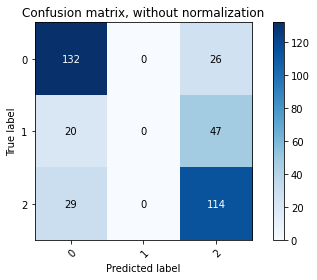

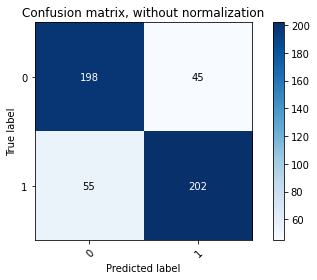

In [ ]:
Test_Val_CONF(MyNetWork)

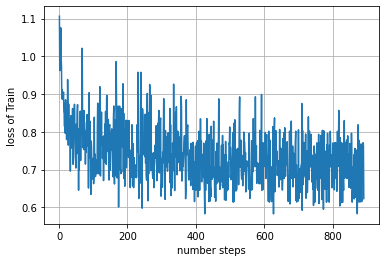

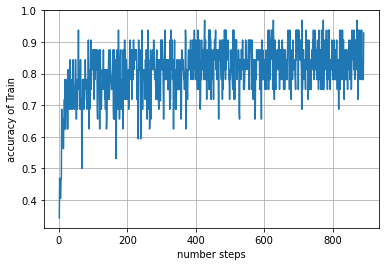

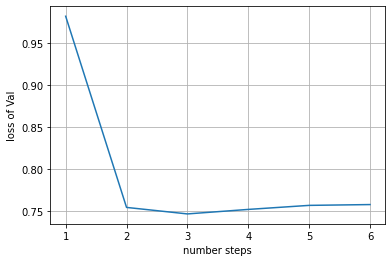

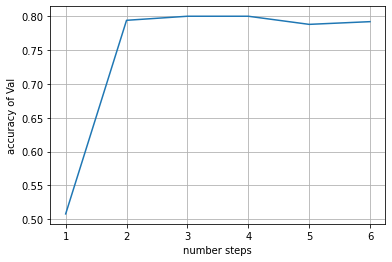

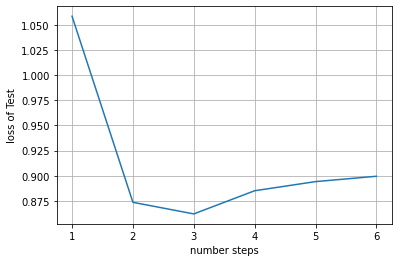

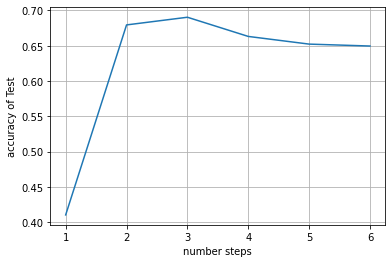

In [ ]:
plot_acc(MyNetWork)